In [1]:
import pandas as pd 

X_train = pd.read_csv("../../datasets/kepler/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/kepler/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/kepler/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/kepler/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/kepler/groups.csv", index_col=0)["kepid"]

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba, title="Metrics vs Threshold"):
    """Plot accuracy, precision, recall, and F1 while sweeping the decision threshold 0..1."""
    thresholds = np.linspace(0.0, 1.0, 501)
    accs, precs, recs, f1s = [], [], [], []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, accs, label="Accuracy")
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [3]:
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

kf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier()
score = cross_validate(model, X_train, y_train, cv=kf, scoring="average_precision", n_jobs=-1, groups=groups)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(f"Score: {score}")

Accuracy: 0.8231865284974094
Precision: 0.925
Recall: 0.5751295336787565
F1: 0.7092651757188498
Score: {'fit_time': array([2.21263003, 1.96529913, 1.82483625, 1.93036819, 1.93767285]), 'score_time': array([0.01036906, 0.01575208, 0.01919699, 0.01605105, 0.02170706]), 'test_score': array([0.93433063, 0.94003781, 0.95210293, 0.94461465, 0.94334407])}


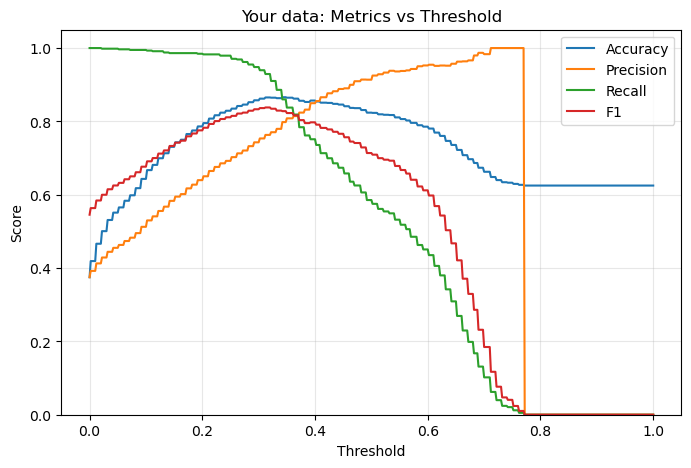

In [4]:
import numpy as np

y_1 = model.predict_proba(X_test)[:, 1]

plot_metrics_vs_threshold(y_test, y_1, title="Your data: Metrics vs Threshold")

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    "max_depth": [20, 40],              
    "min_samples_leaf": [1, 2, 4],         
    "max_features": ["sqrt", 0.5],       
    "class_weight": [None, "balanced_subsample"]
}

models_cv = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, scoring="average_precision", cv=kf, refit=True)
models_cv.fit(X_train, y_train, groups=groups)

best_model = models_cv.best_estimator_ 
print("Best PR-AUC:", models_cv.best_score_)
print("Best params:", models_cv.best_params_)

Best PR-AUC: 0.944607915853965
Best params: {'class_weight': 'balanced_subsample', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2}


In [6]:
from sklearn.metrics import confusion_matrix

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[933  32]
 [233 346]]


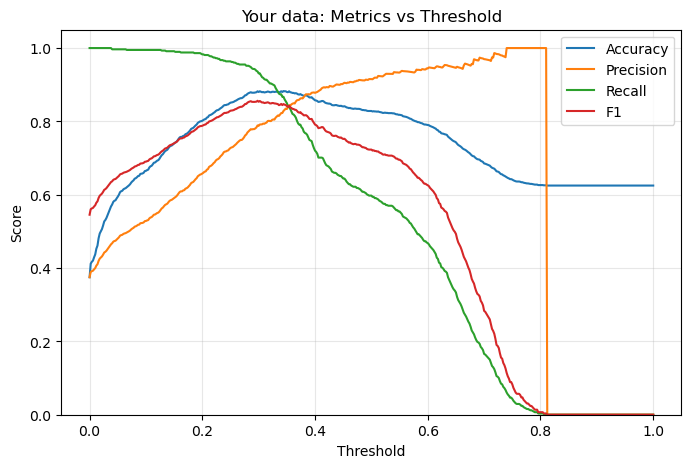

In [7]:
y_2 = best_model.predict_proba(X_test)[:, 1]

plot_metrics_vs_threshold(y_test, y_2, title="Your data: Metrics vs Threshold")

In [8]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_2 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 ≥ 0.80)")
y_pred_thr = (y_2 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.220  (F1 ≥ 0.80)
Precision/Recall/F1 @ thr: 0.6861313868613139 0.9740932642487047 0.8051391862955032
[[707 258]
 [ 15 564]]


In [9]:
from pathlib import Path
import joblib

In [10]:
ARTS = Path("../../saved-models/kepler")
ARTS.mkdir(parents=True, exist_ok=True)

In [11]:
bundle1 = {
    "model": model,
    "threshold": 0.5
}

joblib.dump(bundle1, ARTS / "kepler_RF_v1.pkl")
print("Saved →", ARTS / "kepler_RF_v1.pkl")

Saved → ../../saved-models/kepler/kepler_RF_v1.pkl


In [12]:
bundle2 = {
    "model": best_model,            
    "threshold": thr_star       
}

joblib.dump(bundle2, ARTS / "kepler_RF_best_v1.pkl")
print("Saved →", ARTS / "kepler_RF_best_v1.pkl")

Saved → ../../saved-models/kepler/kepler_RF_best_v1.pkl
